In [1]:
import pandas as pd
import hvplot.pandas
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
from matplotlib import colors
import scipy.stats as st
import seaborn as sns
cm=sns.light_palette("green", as_cmap=True)
cm1=sns.light_palette("red", as_cmap=True)
from warnings import filterwarnings
filterwarnings("ignore")
from config import census_api_key
from config import geoapify_key


In [2]:
population_county_pd = pd.read_csv("Resources/population_county.csv")
population_county_pd['County'] = population_county_pd['County'].str.replace('.', '')
population_county_pd['2020'] = population_county_pd['2020'].str.replace(',', '')
population_county_pd['2021'] = population_county_pd['2021'].str.replace(',', '')
population_county_pd['2022'] = population_county_pd['2022'].str.replace(',', '')
population_county_pd['2023'] = population_county_pd['2023'].str.replace(',', '')
population_county_pd.head()

,County,2020,2021,2022,2023
0,"Autauga County, Alabama",58915,59203,59726,60342
1,"Baldwin County, Alabama",233227,239439,246531,253507
2,"Barbour County, Alabama",24969,24533,24700,24585
3,"Bibb County, Alabama",22188,22359,21986,21868
4,"Blount County, Alabama",59107,59079,59516,59816


## Finding Counties with Highest Population Growth by Number

In [3]:

population_county_pd['2020']=population_county_pd['2020'].astype(int)
population_county_pd['2021']=population_county_pd['2021'].astype(int)
population_county_pd['2022']=population_county_pd['2022'].astype(int)
population_county_pd['2023']=population_county_pd['2023'].astype(int)

In [4]:
pop_growth_percent = population_county_pd.copy()

In [5]:
population_county_pd['Pop Growth from 2020-2023']=population_county_pd['2023']-population_county_pd['2020']
population_county_pd.head()

,County,2020,2021,2022,2023,Pop Growth from 2020-2023
0,"Autauga County, Alabama",58915,59203,59726,60342,1427
1,"Baldwin County, Alabama",233227,239439,246531,253507,20280
2,"Barbour County, Alabama",24969,24533,24700,24585,-384
3,"Bibb County, Alabama",22188,22359,21986,21868,-320
4,"Blount County, Alabama",59107,59079,59516,59816,709


In [6]:
pop_growth_pd = population_county_pd[['County', 'Pop Growth from 2020-2023']].copy()

In [7]:
pop_growth_sorted = pop_growth_pd.sort_values('Pop Growth from 2020-2023', ascending=False)

pop_growth_100 = pop_growth_sorted.iloc[0:100].copy()

In [8]:
pop_100 = pop_growth_100.set_index('County')
pop_100

,Pop Growth from 2020-2023
County,
"Maricopa County, Arizona",140812
"Collin County, Texas",119623
"Harris County, Texas",100333
"Denton County, Texas",93305
"Polk County, Florida",88172
...,...
"Paulding County, Georgia",13584
"Clay County, Florida",13488
"Hunt County, Texas",13093


In [9]:
counties = []
lat = []
lon = []
for row in pop_100.iterrows():
    counties.append(row[0])
len(counties)

100

In [10]:


for county in counties:
    target_county = county
    target_url = f"https://api.geoapify.com/v1/geocode/search?text={target_county}&format=json&apiKey={geoapify_key}"
    response = requests.get(target_url).json()
    lat.append(response["results"][0]["lat"])
    lon.append(response["results"][0]["lon"])
    print(f'Found Latitude and Longitude for {target_county}.')
    
print('Finished searching for Latitude and Longitudes')


Found Latitude and Longitude for Maricopa County, Arizona.
Found Latitude and Longitude for Collin County, Texas.
Found Latitude and Longitude for Harris County, Texas.
Found Latitude and Longitude for Denton County, Texas.
Found Latitude and Longitude for Polk County, Florida.
Found Latitude and Longitude for Fort Bend County, Texas.
Found Latitude and Longitude for Montgomery County, Texas.
Found Latitude and Longitude for Williamson County, Texas.
Found Latitude and Longitude for Bexar County, Texas.
Found Latitude and Longitude for Riverside County, California.
Found Latitude and Longitude for Hillsborough County, Florida.
Found Latitude and Longitude for Lee County, Florida.
Found Latitude and Longitude for Tarrant County, Texas.
Found Latitude and Longitude for Pasco County, Florida.
Found Latitude and Longitude for Clark County, Nevada.
Found Latitude and Longitude for Wake County, North Carolina.
Found Latitude and Longitude for Utah County, Utah.
Found Latitude and Longitude f

In [11]:
pop_100['Latitude']=lat
pop_100['Longitude']=lon

In [12]:
pop_100

,Pop Growth from 2020-2023,Latitude,Longitude
County,,,
"Maricopa County, Arizona",140812,15.683640,-87.332920
"Collin County, Texas",119623,33.160963,-96.606098
"Harris County, Texas",100333,29.811977,-95.374125
"Denton County, Texas",93305,33.183879,-97.141342
"Polk County, Florida",88172,27.944854,-81.726879
...,...,...,...
"Paulding County, Georgia",13584,33.890853,-84.856916
"Clay County, Florida",13488,29.976652,-81.847060
"Hunt County, Texas",13093,33.116157,-96.080892


In [13]:
pop_100.to_csv('Resources/PopulationGrowthTop100.csv')

In [14]:
# Obtained Median Income for Top 100 Counties by Population Growth from: https://www.census.gov/quickfacts/

top100_median_df = pd.read_csv("Resources/Top100Medianincome.csv")
top100_median_df.set_index('County')

,Median Income
County,
"Maricopa County, Arizona",80675
"Collin County, Texas",113255
"Harris County, Texas",70789
"Denton County, Texas",71921
"Polk County, Florida",60901
...,...
"Paulding County, Georgia",89237
"Clay County, Florida",82242
"Hunt County, Texas",66885


In [15]:
pop_100median = pop_100.merge(top100_median_df, on='County')
pop_100median['Median Income'].astype(int)
pop_100median['Pop Growth from 2020-2023'].astype(int)
pop_100median = pop_100median[['County', 'Pop Growth from 2020-2023', 'Median Income', 'Latitude', 'Longitude']]
pop_100display = pop_100median.set_index('County').copy()
pop_100display
pop_100display.style.background_gradient(subset=['Median Income'], cmap=cm).format({
    'Median Income':"${:,.0f}", 'Pop Growth from 2020-2023':"{:,.0f}"})


,Pop Growth from 2020-2023,Median Income,Latitude,Longitude
County,,,,
"Maricopa County, Arizona","140,812","$80,675",15.683640,-87.332920
"Collin County, Texas","119,623","$113,255",33.160963,-96.606098
"Harris County, Texas","100,333","$70,789",29.811977,-95.374125
"Denton County, Texas","93,305","$71,921",33.183879,-97.141342
"Polk County, Florida","88,172","$60,901",27.944854,-81.726879
"Fort Bend County, Texas","87,669","$109,987",29.511218,-95.780735
"Montgomery County, Texas","86,063","$95,946",30.301949,-95.506594
"Williamson County, Texas","81,639","$102,851",30.658093,-97.604165
"Bexar County, Texas","72,178","$67,275",29.426399,-98.510478


The correlation between Population growth and Median Income is -0.07.


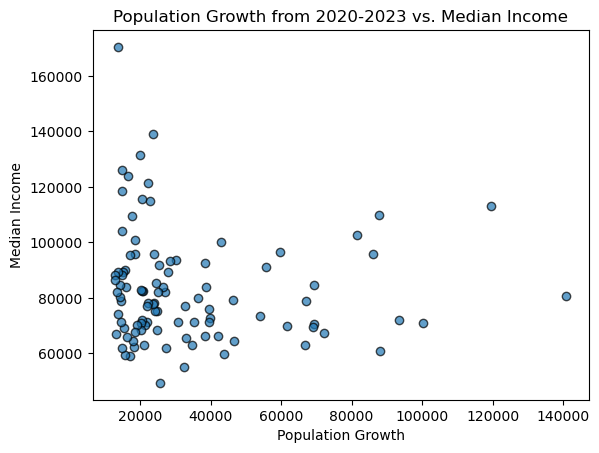

In [16]:
# Is there a correlation between population growth and median income?

x_value = pop_100median['Pop Growth from 2020-2023']
y_value = pop_100median['Median Income']
corr_coefficient = st.pearsonr(x_value, y_value)
print(f"The correlation between Population growth and Median Income is {round(corr_coefficient[0],2)}.")
plt.scatter(x_value, y_value, alpha=0.7, edgecolors='black')
plt.xlabel('Population Growth')
plt.ylabel('Median Income')
plt.title('Population Growth from 2020-2023 vs. Median Income')
plt.show()
# No.  there is no correlation between Population Growth and Median Income

In [17]:
#Plot of top 100 counties in Population Growth

pop100_mapplot=pop_100median.copy()
pop100_mapplot['Median Income']=pop100_mapplot['Median Income'].map("${:,.0f}".format)
pop100_mapplot['Pop Growth from 2020-2023']=pop100_mapplot['Pop Growth from 2020-2023'].map("{:,.0f}".format)

mapplot = pop100_mapplot.hvplot.points('Longitude', 'Latitude', geo=True, tiles='OSM', legend=False,
                                    frame_width= 700, frame_height=500, alpha = 0.5, color = 'County', 
                                    hover_cols=['Longitude', 'Latitude', 'County', 
                                                'Pop Growth from 2020-2023', 'Median Income'])
mapplot

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]   (County,Pop Growth from 2020-2023,Median Income)

## Finding Counties with the Highest Population Growth %

In [18]:
len(pop_growth_percent)

3144

In [19]:
pop_growth_percent['Pop Growth % from 2020-2023']=population_county_pd['2023']/population_county_pd['2020']*100-100
pop_growth_percent.head()

,County,2020,2021,2022,2023,Pop Growth % from 2020-2023
0,"Autauga County, Alabama",58915,59203,59726,60342,2.422134
1,"Baldwin County, Alabama",233227,239439,246531,253507,8.695391
2,"Barbour County, Alabama",24969,24533,24700,24585,-1.537907
3,"Bibb County, Alabama",22188,22359,21986,21868,-1.442221
4,"Blount County, Alabama",59107,59079,59516,59816,1.199520


In [20]:
pop_growth_percent = pop_growth_percent.sort_values('Pop Growth % from 2020-2023', ascending=False)

pop_growth_percentmerge = pop_growth_percent.iloc[0:100].copy()
pop_growth_percentmerge = pop_growth_percentmerge[['County', 'Pop Growth % from 2020-2023']].set_index('County')
pop_growth_percentmerge

,Pop Growth % from 2020-2023
County,
"Kaufman County, Texas",26.199538
"Long County, Georgia",20.430240
"Rockwall County, Texas",20.290771
"Comal County, Texas",18.495164
"Dawson County, Georgia",17.269670
...,...
"Gem County, Idaho",9.334786
"Bay County, Florida",9.307549
"Hood County, Texas",9.212498


In [21]:
counties1 = []
lat1 = []
lon1 = []
for row in pop_growth_percentmerge.iterrows():
    counties1.append(row[0])

for county in counties1:
    target_county = county
    target_url = f"https://api.geoapify.com/v1/geocode/search?text={target_county}&format=json&apiKey={geoapify_key}"
    resp = requests.get(target_url).json()
    lat1.append(resp["results"][0]["lat"])
    lon1.append(resp["results"][0]["lon"])
    print(f'Found Latitude and Longitude for {target_county}.')
    
print('Finished searching for Latitude and Longitudes')

pop_growth_percentmerge['Latitude']=lat1
pop_growth_percentmerge['Longitude']=lon1


Found Latitude and Longitude for Kaufman County, Texas.
Found Latitude and Longitude for Long County, Georgia.
Found Latitude and Longitude for Rockwall County, Texas.
Found Latitude and Longitude for Comal County, Texas.
Found Latitude and Longitude for Dawson County, Georgia.
Found Latitude and Longitude for Custer County, Colorado.
Found Latitude and Longitude for Broadwater County, Montana.
Found Latitude and Longitude for Liberty County, Texas.
Found Latitude and Longitude for Sumter County, Florida.
Found Latitude and Longitude for Parker County, Texas.
Found Latitude and Longitude for Brunswick County, North Carolina.
Found Latitude and Longitude for St Johns County, Florida.
Found Latitude and Longitude for Jackson County, Georgia.
Found Latitude and Longitude for Jasper County, South Carolina.
Found Latitude and Longitude for Hays County, Texas.
Found Latitude and Longitude for Ellis County, Texas.
Found Latitude and Longitude for Chambers County, Texas.
Found Latitude and Lon

In [22]:
pop_growth_percentmerge

,Pop Growth % from 2020-2023,Latitude,Longitude
County,,,
"Kaufman County, Texas",26.199538,32.601641,-96.337513
"Long County, Georgia",20.430240,31.770490,-81.753725
"Rockwall County, Texas",20.290771,32.892346,-96.406699
"Comal County, Texas",18.495164,29.797970,-98.269079
"Dawson County, Georgia",17.269670,34.407708,-84.135677
...,...,...,...
"Gem County, Idaho",9.334786,44.012302,-116.384661
"Bay County, Florida",9.307549,30.248169,-85.659363
"Hood County, Texas",9.212498,32.410756,-97.828282


In [23]:
pop_growth_percentmerge.to_csv('Resources/Population%Top100.csv')

In [24]:
# Obtained Median Income for Top 100 Counties by Population Growth from: https://www.census.gov/quickfacts/

top100percent_median_df = pd.read_csv("Resources/Top100%Medianincome.csv")
top100percent_median_df.set_index('County')

,Median Income
County,
"Kaufman County, Texas",NaN
"Long County, Georgia",NaN
"Rockwall County, Texas",NaN
"Comal County, Texas",NaN
"Dawson County, Georgia",NaN
...,...
"Gem County, Idaho",NaN
"Bay County, Florida",NaN
"Hood County, Texas",NaN


In [25]:
top100percent_median = pop_growth_percentmerge.merge(top100percent_median_df, on='County')
#top100percent_median['Median Income'].astype(int)
#top100percent_median['Pop Growth % from 2020-2023'].astype(int)
top100percent_median = top100percent_median[['County', 'Pop Growth % from 2020-2023', 'Median Income', 'Latitude', 'Longitude']]
pop_100percentdisplay = top100percent_median.set_index('County').copy()
pop_100percentdisplay
pop_100percentdisplay.style.background_gradient(subset=['Median Income'], cmap=cm).format({
    'Median Income':"${:,.0f}", 'Pop Growth % from 2020-2023':"{:,.0f}"})

,Pop Growth % from 2020-2023,Median Income,Latitude,Longitude
County,,,,
"Kaufman County, Texas",26,$nan,32.601641,-96.337513
"Long County, Georgia",20,$nan,31.770490,-81.753725
"Rockwall County, Texas",20,$nan,32.892346,-96.406699
"Comal County, Texas",18,$nan,29.797970,-98.269079
"Dawson County, Georgia",17,$nan,34.407708,-84.135677
"Custer County, Colorado",17,$nan,38.107296,-105.354337
"Broadwater County, Montana",17,$nan,43.408898,23.220319
"Liberty County, Texas",17,$nan,30.085674,-94.785626
"Sumter County, Florida",16,$nan,28.668975,-82.076402


In [26]:
#Plot of top 100 counties in Population Growth

pop100percent_mapplot=top100percent_median.copy()
#pop100_mapplot['Median Income']=pop100_mapplot['Median Income'].map("${:,.0f}".format)
#pop100percent_mapplot['Pop Growth % from 2020-2023']=pop100percent_mapplot['Pop Growth % from 2020-2023'].map("{:,.0f}".format)

mapplot = pop100percent_mapplot.hvplot.points('Longitude', 'Latitude', geo=True, tiles='OSM', legend=False,
                                    frame_width= 700, frame_height=500, alpha = 0.5, color = 'County', 
                                    hover_cols=['Longitude', 'Latitude', 'County', 
                                                'Pop Growth % from 2020-2023', 'Median Income'])
mapplot

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]   (County,Pop Growth % from 2020-2023,Median Income)

## Merge Pop Growth by % and Pop Growth by Numbers to find overlap

In [27]:
pop_merged = pop_growth_percentmerge.merge(pop_100, on='County', how='inner')

In [28]:
pop_merged

,Pop Growth % from 2020-2023,Latitude_x,Longitude_x,Pop Growth from 2020-2023,Latitude_y,Longitude_y
County,,,,,,
"Kaufman County, Texas",26.199538,32.601641,-96.337513,38550,32.601641,-96.337513
"Rockwall County, Texas",20.290771,32.892346,-96.406699,22149,32.892346,-96.406699
"Comal County, Texas",18.495164,29.797970,-98.269079,30269,29.797970,-98.269079
"Liberty County, Texas",17.077391,30.085674,-94.785626,15793,30.085674,-94.785626
"Sumter County, Florida",16.328958,28.668975,-82.076402,21275,28.668975,-82.076402
"Parker County, Texas",16.009147,32.777260,-97.804560,23942,32.777260,-97.804560
"Brunswick County, North Carolina",15.774999,34.071819,-78.191422,21796,34.071819,-78.191422
"St Johns County, Florida",15.521889,29.903228,-81.414547,43011,29.903228,-81.414547
"Hays County, Texas",14.968357,30.044790,-98.039313,36518,30.044790,-98.039313


In [29]:
len(pop_merged)

36